# Basis embedding (qiskit)

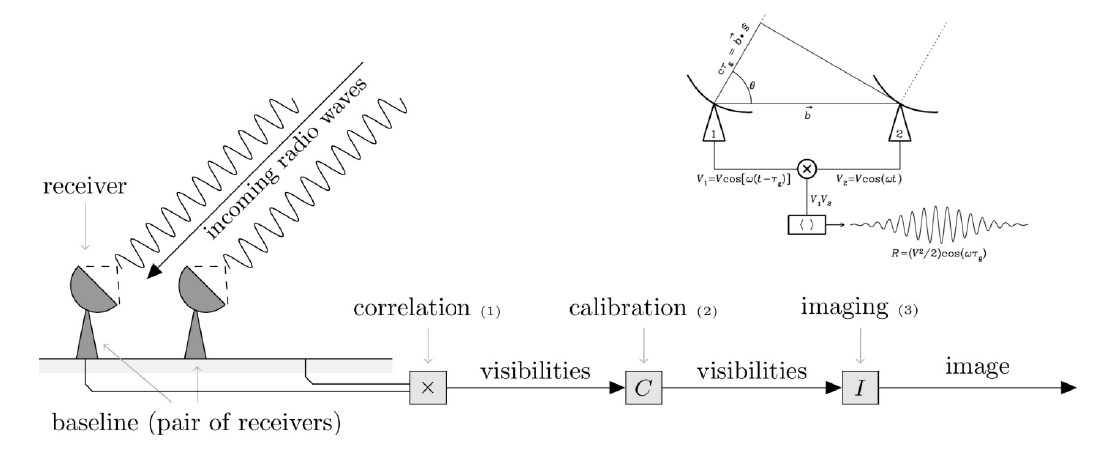

*First pipeline:*
* **1. Data preparation (correlation step):**
    * 1.1 image initialization (spatial domain)
    * 1.2 Fourier transform (frequency domain)
    
    &rarr; simulates radio visibility data
* **2. Data embedding (calibration step):**
    * 2.1 data pre-processing
    * 2.2 data encoding
    
    &rarr; embeds visibilities into qubits
* **3. Data reading (imaging step):**
    * 3.1 readout
    * 3.2 inverse Fourier transform (spatial domain) - IFT
    
    &rarr; approximates science-ready intermediate product  

*Second pipeline:*
* **1. Data preparation (correlation step):**
     * 1.1 image initialization (spatial domain)
     * 1.2 Fourier transform (frequency domain)
     
     &rarr; simulates radio visibility data
* **2. Data embedding (calibration step):**
    * 2.1 data pre-processing
    * 2.2 data encoding
    * 2.3 quantum inverse Fourier transform - QFT
    
    &rarr; embeds visibilities into qubits and applies QFT on qubits
* **3. Data reading (imaging step):**
    * 3.1 readout
    
    &rarr; approximates science-ready intermediate product  

*Basis embedding:*

* circuit family #1 from [Cortese 2018](https://arxiv.org/abs/1803.01958)
* to many features for PennyLane's implementation ([Teamplates](https://docs.pennylane.ai/en/stable/introduction/templates.html))

#### Prerequisites

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import qiskit
from qiskit import *

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

# reverse a string (for the measurement step readout)
def reverse(string):
    string = string[::-1]
    return string

## 1. Data preparation (correlation step)

### 1.1 image initialization (spatial domain)

In [3]:
# image of the sky filled with double precision complex floats 
# few pixels are set to relatively large complex random values in random spots (image sources)
# relatively small complex values are added (white noise from background radiations) 

n = 10 #number of antennas

sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
stars = np.random.randint(3, 11) #random number of sources
radius = 3 #np.random.randint(1, 3) #with random radius

for i in range(0, stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[-4.56518214e-03-7.11322855e-03j  4.37478209e-03+4.06756671e-03j
  -9.07051872e-05-4.24400484e-03j -8.78597610e-03+9.57470108e-03j
   2.43487535e-03+1.90694060e-03j -5.05524082e-03+1.10126128e-02j
   1.62791703e-02-5.13504550e-04j  1.37562538e-02+1.22962927e-03j
  -1.21174455e-02+1.32053597e-02j  5.72655397e-03-1.12618115e-02j]
 [-7.44921854e-03-7.71767553e-03j -5.25432639e-03-6.57882309e-03j
   5.95896339e+01+6.10655785e+01j  6.91090317e+01+9.92433834e+00j
   2.00023212e+01+8.89952316e+01j -6.40925765e-03-2.72501912e-03j
   8.97550125e+01+3.13386440e+00j  1.71563606e+01+6.92729492e+01j
   5.43591347e+01+4.91475773e+00j  5.90744987e-03-5.87279443e-03j]
 [ 9.37073212e-03+6.50230795e-04j -7.65189715e-03+1.04223061e-02j
   7.26859589e+01+1.25955925e+01j  4.64050140e+01+9.38573303e+01j
   7.89027939e+01+1.30392094e+01j -6.25140499e-03-2.98309466e-03j
   7.01182127e+00+4.94588776e+01j  5.91969919e+00+9.70504608e+01j
   3.88292503e+01+3.41450920e+01j  1.20510440e-02+7.21774576e-03j]
 [ 2.13

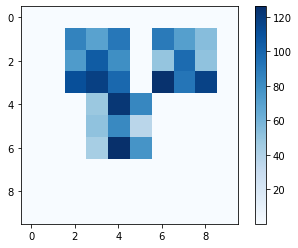

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues') 
plt.colorbar();

### 1.2 Fourier transform (frequency domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[1510.3066   +1389.592j    -326.75824   -950.8206j
  -603.8445     -20.024837j  176.197     +143.30208j
  -164.22849    -70.45707j   481.65176   +167.6633j
   -35.67436    -99.37558j  -107.713394  +353.7495j
   -68.96659   -617.39636j  -861.06335   -296.19406j ]
 [ 555.79956  -1178.8357j   -255.0703    +620.3484j
  -280.04517    -76.399864j  147.63765   +318.44482j
  -159.12617    -80.521385j  227.10863   -394.32254j
    63.33001   +204.07098j   231.50826   -232.20293j
  -867.32      +459.4351j    336.17093   +359.67694j ]
 [ -80.4741    -350.31793j   -96.22189    -90.246414j
    63.695576  +464.57513j   354.2517    -252.92001j
  -181.41853   +172.29648j  -347.6901    -170.3168j
   327.3736     -87.384155j -228.82423     -9.830033j
   409.2846    +330.14963j  -221.00922     -6.213209j]
 [-140.23338   +119.08591j   155.6956     +98.51425j
   -62.338516  -106.24747j    48.35735   -247.55614j
   -97.70358   +192.01343j   112.48519   +274.6167j
   -69.97584   -356.90887j   -37.758686  +13

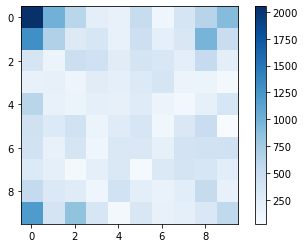

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

#### * Sanity check

In [7]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 6.641119e-13
Imaginaries MSE: 4.1190722e-13


## 2. Data embedding (calibration step)

### 2.1 data pre-processing
### 2.2 data encoding

In [8]:
# encoding binary data onto qubits
def circuit1(qc, binary, off_set):
    
    for i in range(0, len(binary)):
        qc.reset(off_set+i) # set quantum state |0> by default for all qubits

        if binary[i]=='1':
            qc.x(off_set+i) # act as a CX (controlled X gate)
    
    off_set += len(binary)

    return off_set

In [9]:
number_of_entries = visibilities.shape[0] * visibilities.shape[1]
number_of_bits_real = 32
number_of_bits_imag = 32
number_of_bits = number_of_bits_real + number_of_bits_imag
off_set = 0

# encoding (n bits encoded onto n qubits)
qc = QuantumCircuit(number_of_entries*number_of_bits)
for i in range(0, visibilities.shape[0]):
    for j in range(0, visibilities.shape[1]):
            binary_real = float_to_bin_real(visibilities[i, j].real)
            binary_imag = float_to_bin_imag(visibilities[i, j].imag)
            binary = binary_real+binary_imag
            off_set = circuit1(qc, binary, off_set)

## 3. Data reading

### 3.1 readout

In [10]:
# measurement
qc.measure_all()
backend = Aer.get_backend('aer_simulator') # Qiskit's staple simulator (CHOICE MOTIVATION?)
job = backend.run(qc, shots=1, memory=True) 
output = job.result().get_memory()[0]
out = reverse(output)

# readout
chunks_real = []
chunks_imag = []
for i in range(0, number_of_entries):
    chunks_real.append(out[number_of_bits*i:(number_of_bits*i)+number_of_bits_real]) # real parts represented every 64 bits starting from the first one
    chunks_imag.append(out[(number_of_bits*i)+number_of_bits_imag:(number_of_bits*i)+number_of_bits_imag+number_of_bits_imag]) # imaginary parts represented every 64 bits starting after the first occurence of a real part 

readout = []
for i in range(0, len(chunks_real)):
    readout.append(complex(bin_to_float_real(chunks_real[i]), bin_to_float_imag(chunks_imag[i]))) 

readout = np.array(readout).reshape(n , n).astype('complex64')
print(readout)

[[1510.3066   +1389.592j    -326.75824   -950.8206j
  -603.8445     -20.024837j  176.197     +143.30208j
  -164.22849    -70.45707j   481.65176   +167.6633j
   -35.67436    -99.37558j  -107.713394  +353.7495j
   -68.96659   -617.39636j  -861.06335   -296.19406j ]
 [ 555.79956  -1178.8357j   -255.0703    +620.3484j
  -280.04517    -76.399864j  147.63765   +318.44482j
  -159.12617    -80.521385j  227.10863   -394.32254j
    63.33001   +204.07098j   231.50826   -232.20293j
  -867.32      +459.4351j    336.17093   +359.67694j ]
 [ -80.4741    -350.31793j   -96.22189    -90.246414j
    63.695576  +464.57513j   354.2517    -252.92001j
  -181.41853   +172.29648j  -347.6901    -170.3168j
   327.3736     -87.384155j -228.82423     -9.830033j
   409.2846    +330.14963j  -221.00922     -6.213209j]
 [-140.23338   +119.08591j   155.6956     +98.51425j
   -62.338516  -106.24747j    48.35735   -247.55614j
   -97.70358   +192.01343j   112.48519   +274.6167j
   -69.97584   -356.90887j   -37.758686  +13

### 3.2 inverse Fourier transform (spatial domain)

In [11]:
img = np.fft.ifft2(readout).astype('complex64')

#### fidelity test

In [12]:
test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 6.641119e-13
Imaginaries MSE: 4.1190722e-13


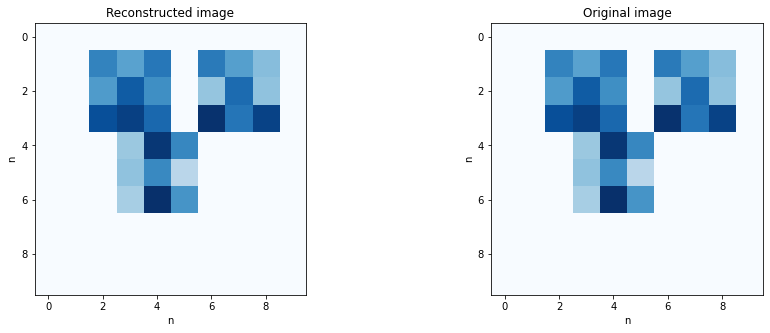

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Blues')
axs[1].imshow(modulus2, cmap='Blues')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')